# 1. Set-up and Cleaning data


## 1.1 Import Libraries

In [2]:
# Importing tensorflow and checking its latest version
import tensorflow as tf
print(tf.__version__)


2.15.0


In [3]:
#Import ImageDataGenerator for data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Define the path to your dataset
dataset_path = 'path/to/defungi'



## 1.2 Data Inspection
Check for Corrupt Files: Identifying and removing corrupt images is important because they can cause errors during the model training process or skew the model's learning.
Image Quality Check: Manually inspecting a sample of images helps assess their quality in terms of focus, lighting, and clarity. Poor-quality images can negatively impact the model's ability to learn.

In [4]:
# Check for corrupt files and remove them if any.
import os
from PIL import Image

def check_for_corrupt_files(directory):
    corrupt_files = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                with Image.open(filepath) as img:
                    img.verify()  
            except (IOError, SyntaxError) as e:
                corrupt_files.append(filepath)

    return corrupt_files

directory = 'path/to/defungi'  
corrupt_files = check_for_corrupt_files(directory)

if corrupt_files:
    print("Found corrupt or unreadable files:")
    for file in corrupt_files:
        print(file)
else:
    print("No corrupt files found.")

No corrupt files found.


In [5]:
# Check the quality of the images
import numpy as np

def check_image_quality(directory, threshold=0.05):
    """
    Checks for images that are too dark or too bright, indicating potential quality issues.
    :param directory: Directory containing the image dataset.
    :param threshold: Fraction of pixels that are either black or white to consider the image as poor quality.
    """
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                with Image.open(filepath) as img:
                    img_array = np.array(img)
                    # Check if the image is grayscale or colored
                    if len(img_array.shape) == 2 or img_array.shape[2] == 1:  # Grayscale image
                        n_white = np.sum(img_array >= 255)
                        n_black = np.sum(img_array <= 0)
                    else:  # Colored image
                        n_white = np.sum(np.all(img_array >= [255, 255, 255], axis=2))
                        n_black = np.sum(np.all(img_array <= [0, 0, 0], axis=2))

                    # Check if the image has too many black or white pixels
                    if (n_white + n_black) / img_array.size > threshold:
                        print(f'Image {file} in {subdir} might be of poor quality')
            except IOError:
                # This can catch errors in opening the image file
                print(f'Error opening {file} in {subdir}')

check_image_quality('path/to/defungi')

## 1.3 Data Cleaning
We now check for blurred images and do Aspect Ratio Normalization to resize the images while maintining their originl aspect rtio to prevent distortion. We then enhance the images and print one of the enhanced image as an example. 

In [6]:
! pip install opencv-python-headless Pillow scikit-image

In [7]:
# Check for blurred images
import cv2
import numpy as np

def is_blurred(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < 100  # threshold for blurriness; adjust as needed


In [8]:
# Resizing the images while maintaining their original aspect ratio
from PIL import Image

def normalize_aspect_ratio(image_path, desired_size=224):
    image = Image.open(image_path)
    old_size = image.size

    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    image = image.resize(new_size, Image.ANTIALIAS)

    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(image, ((desired_size - new_size[0]) // 2,
                        (desired_size - new_size[1]) // 2))

    return new_im

In [9]:
# Enhancing the images
def enhance_image(image_path):
    image = cv2.imread(image_path)
    return cv2.detailEnhance(image, sigma_s=10, sigma_r=0.15)

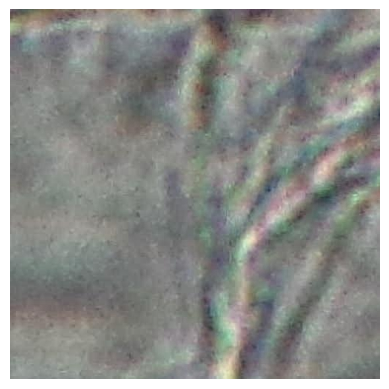

In [10]:
# Printing one of the images
import cv2
from matplotlib import pyplot as plt

# Define the path to the uploaded image, including the file name
image_path = 'defungi/H1/H1_1a_1.jpg'

# Define the image enhancement function
def enhance_image(image_path):
    image = cv2.imread(image_path)
    # Check if the image was correctly loaded
    if image is not None:
        enhanced_image = cv2.detailEnhance(image, sigma_s=10, sigma_r=0.15)
        return enhanced_image
    else:
        raise FileNotFoundError(f"No image found at {image_path}")

# Enhance the image
enhanced = enhance_image(image_path)

# Convert color from BGR to RGB (OpenCV uses BGR by default)
enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(enhanced_rgb)
plt.axis('off')  # Turn off axis numbers
plt.show()

## Data Transformation 
Resizing Images: CNNs require that all images have the same size. Resizing standardizes the input, making it possible to design and train the network.

Normalizing Pixel Values: By scaling the pixel intensities to a range [0, 1], it helps in maintaining numerical stability in the network, as smaller, normalized values make the optimization process more efficient and reliable.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator class.
# We will apply several transformations to augment our dataset which helps to prevent overfitting.

datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the image by normalizing pixel values to [0,1]
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 20)
    width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=0.2  # Reserve 20% of the data for validation
)

# Create a training data generator.
# This will read images from the directory, apply transformations, and serve them to the model.
train_generator = datagen.flow_from_directory(
    'defungi/',  # This is the path to the training data.
    target_size=(224, 224),  # Resize all images to 224x224 to fit the model expected input
    batch_size=32,  # The size of the batches of data (number of images to be yielded from the generator per batch).
    class_mode='categorical',  # Since we are doing multi-class classification
    subset='training'  # Set as training data
)

# Create a validation data generator.
# It is similar to the training data generator but without the data augmentation part.
# It will only rescale the pixel values.
validation_generator = datagen.flow_from_directory(
    'defungi/',  # Path to the validation data, same as training since the split is made by the generator.
    target_size=(224, 224),  # The images are resized to 224x224 for the same reason as above.
    batch_size=32,  # Same batch size as training
    class_mode='categorical',  # Same class mode as training
    subset='validation'  # Set as validation data
)


Found 7295 images belonging to 5 classes.
Found 1819 images belonging to 5 classes.


# 2 Exploratory Data Analysis (EDA)

## 2.1 Visual Inspection of the Images


Found 9114 images belonging to 5 classes.


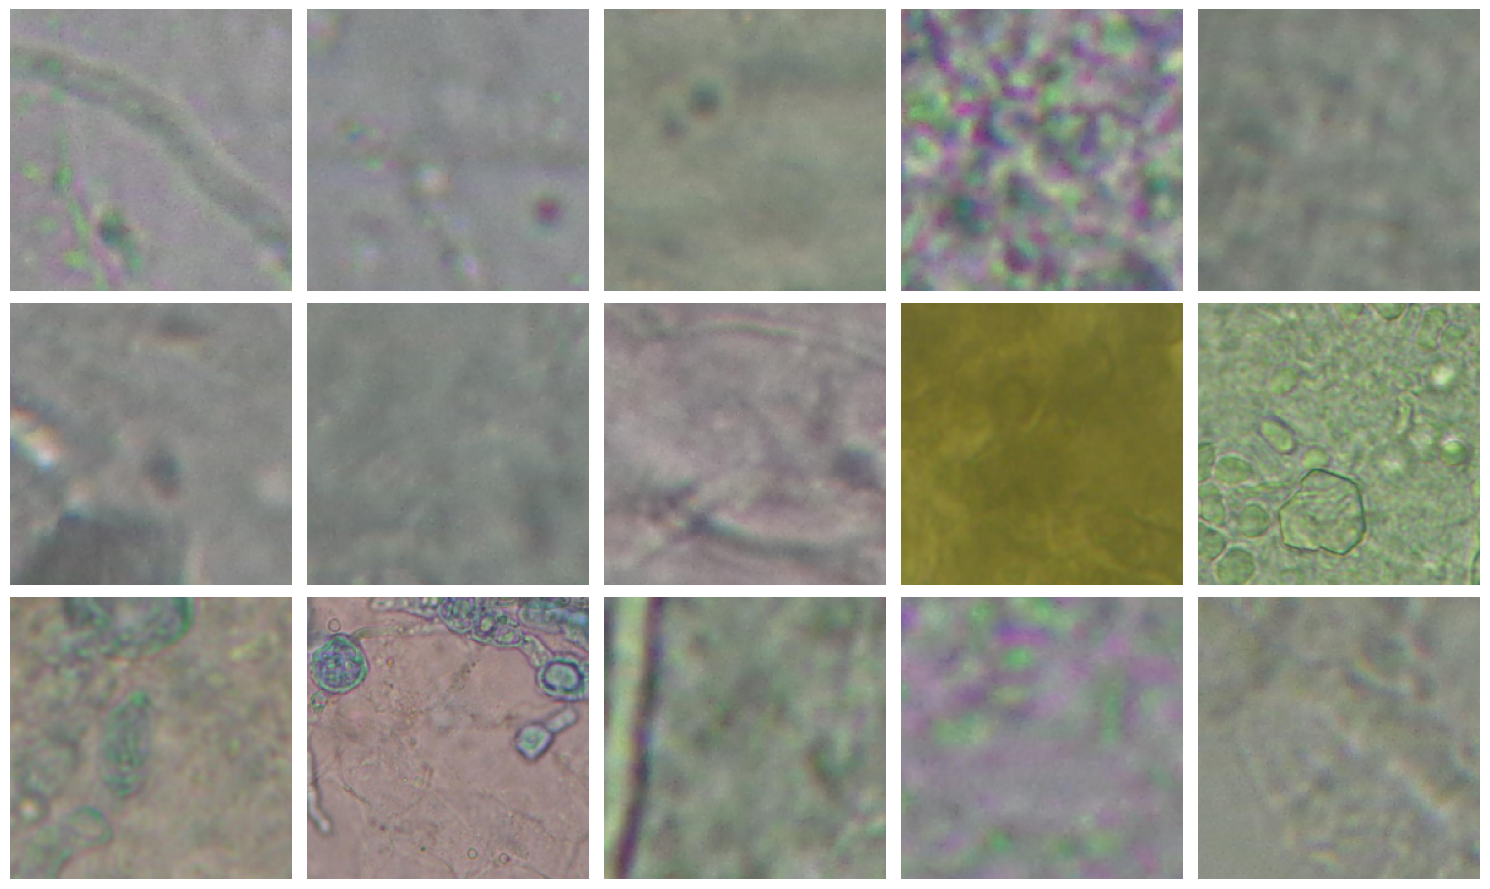

In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a new generator without augmentation to view original images
view_datagen = ImageDataGenerator(rescale=1./255)


view_generator = view_datagen.flow_from_directory(
    directory='defungi',
    target_size=(224, 224),
    batch_size=15,  # Display 15 images at a time for visual inspection
    class_mode='categorical',
    shuffle=True)  # Shuffle to get a random set of images

# Get a batch of images
images, labels = next(view_generator)

# Plot the images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # Adjust the grid size based on batch size
axes = axes.flatten()
for img, lbl, ax in zip(images, labels, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

## 2.2 Label Distribution Analysis
We will quantify how many images are present in each class and to check for class imbalance. 

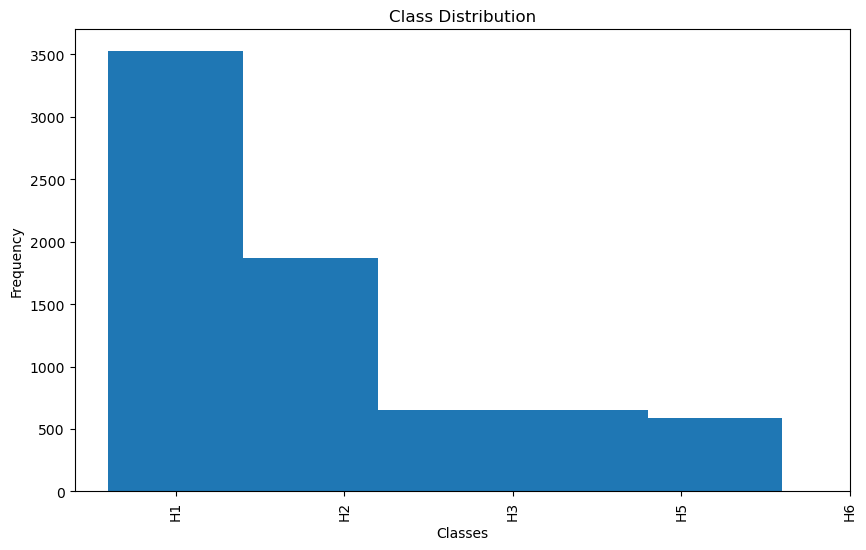

In [13]:
# This code analyzes the distribution of classes (labels) in the dataset.

import matplotlib.pyplot as plt

# Assuming class labels are available in the 'classes' attribute of the generator
class_labels = train_generator.classes
class_indices = train_generator.class_indices

plt.figure(figsize=(10, 6))
plt.hist(class_labels, bins=len(class_indices), align='left')
plt.xticks(ticks=range(len(class_indices)), labels=class_indices.keys(), rotation=90)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

## 2.3 Pixel Intensity Analysis
We analyze the distribution of pixel intensities across the dataset which can give insights into the contrast, brightness, and quality of images.

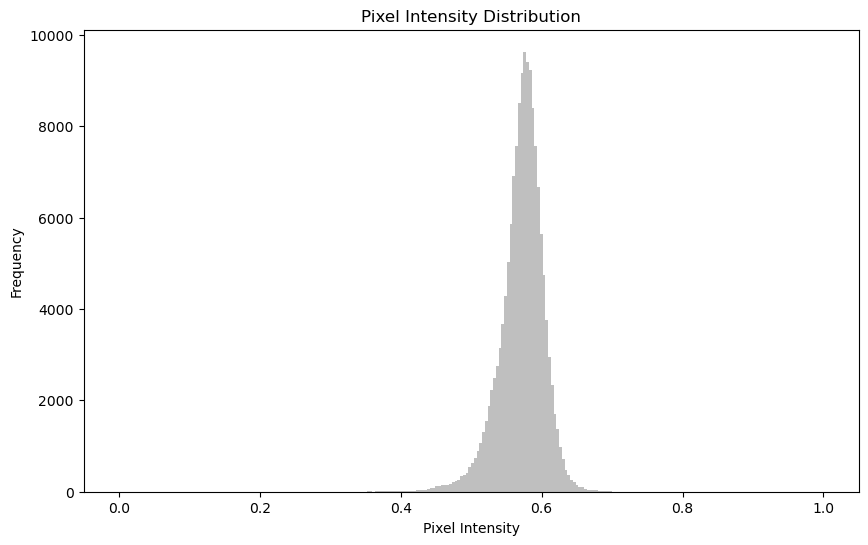

In [14]:
import numpy as np

# Select one image from our batch
sample_image = images[0]  # Taking the first image for example

# Flatten the image to collapse the 3D shape into 1D
flattened_image = sample_image.flatten()

# Plot the histogram of pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(flattened_image, bins=256, range=[0,1], color='gray', alpha=0.5)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

The shape of the histogram suggests that most pixels in the image(s) are of medium intensity, with fewer pixels at the extremes (very dark or very light). The peak around the middle (around 0.5) suggests a large concentration of mid-tone values. 

 This suggests that, on average, the images are neither too dark nor too light, which is generally good for training our model later.

## 2.4 Data Visualization
Visualizations can reveal trends and patterns that might not be apparent from raw data. They are essential for communicating findings to stakeholders and for making informed decisions about model development and data preprocessing.

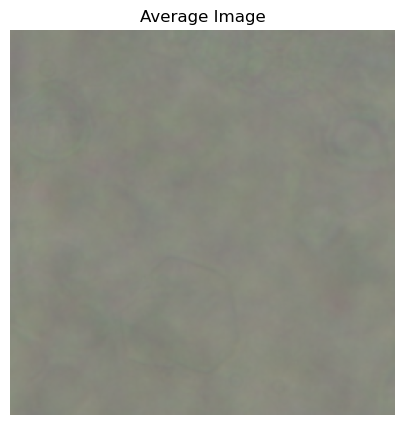

In [17]:
# Calculate the average image
average_image = np.mean(images, axis=0)

# Display the average image
plt.figure(figsize=(5, 5))
plt.imshow(average_image, cmap='gray')
plt.axis('off')
plt.title('Average Image')
plt.show()

# 3 Modeling 


### Split images from `/data/defungi` folder into train, test and validation sets using  install [split-folders](https://pypi.org/project/split-folders/0.3.1/) library

In [ ]:
! pip install split-folders tqdm

In [ ]:
#Good old imports
import splitfolders
import os
import pandas as pd

#use  tf version 2.9.0 and up to import from utils
# from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import img_to_array, array_to_img, img_to_array, load_img, ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense



In [ ]:
#load the data and split the data into train, test and validation 

#define path 
path = "data/defungi"

classes = os.listdir(path)
print(len(classes),"Folders Found")

for folder in classes:
  num_items = len(os.listdir(os.path.join(path, folder)))
  print(folder + ":", num_items, " items")


5 Folders Found
H1: 4404  items
H2: 2334  items
H3: 819  items
H5: 818  items
H6: 739  items


In [ ]:
# # Split with a ration of items for each set.
# splitfolders.ratio(path, output="data/split-defungi",
#     seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [ ]:
#preview the number of items in each split
for i, value in enumerate(classes):
    
    print(f"\nClass {value}: ")
    
    for folder in os.listdir("data/split-defungi"):
       
        print(folder, ":",len(os.listdir(os.path.join("data/split-defungi"+"/"+folder, classes[i]))))
        # values = {split:count for }


Class H1: 
test : 441
train : 3523
val : 440

Class H2: 
test : 234
train : 1867
val : 233

Class H3: 
test : 83
train : 655
val : 81

Class H5: 
test : 83
train : 654
val : 81

Class H6: 
test : 75
train : 591
val : 73


splits appear to have worked well. 

### Preview some images 

In [ ]:
#preview some images from each class 
train_data_dir = 'data/split-defungi/train/'
val_data_dir  = 'data/split-defungi/val/'
test_data_dir = 'data/split-defungi/test/'

In [ ]:
# Get all the data in the directory data/split-defungi/test/ and reshape them
print("\nTest...")

test_generator = ImageDataGenerator().flow_from_directory(test_data_dir)

# Get all the data in the directory data/split-defungi/test/, and reshape them
print("\nTrain...")
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir)

print("\nValidation...")
val_generator = ImageDataGenerator().flow_from_directory(val_data_dir)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(test_generator)


Test...
Found 916 images belonging to 5 classes.

Train...
Found 7290 images belonging to 5 classes.

Validation...
Found 908 images belonging to 5 classes.


<mark> *interesting observation:* </mark>
* *we find 5 classes even though our folders are labelled H1 through H6. Turns out H4 is missing!*

[1. 0. 0. 0. 0.]


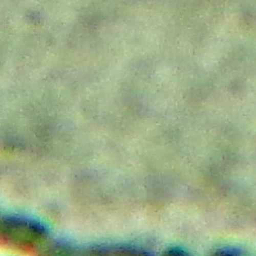

In [ ]:
#preview an image or two
print(train_labels[0])
array_to_img((train_images[0]))


[1. 0. 0. 0. 0.]


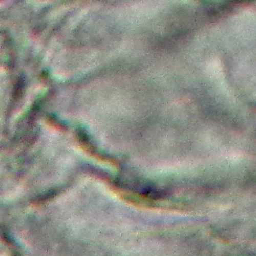

In [ ]:
print(val_labels[8])
array_to_img((val_images[8]))

## Baseline Model: Multi-Layer Perceptron 

MLPs take inputs as vectors, and not matrices/tensors. 

In [ ]:
#check the shape of our input 
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)


_Interpretation:_
For the batch we collected, each set contains 32 items. Image dimensions are the default `ImageGenerator()` image size of 256 x 256, and each image is a color image with 3 dimensions.

To convert these tensors to vectors for use with our MLP, we'll flatten the 2nd, 3rd, and 4th dimensions to have a shape of (32, 256X256X3).

Many machine learning algorithms expect input data in the form of a 2D array, where each row represents a single sample and each column represents a feature.


In [ ]:
#reshape the images so each will be a 1D vector
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

In [ ]:
# See shapes of reshaped inputs

print(train_img.shape)
print(val_img.shape)
print(test_img.shape)

(32, 196608)
(32, 196608)
(32, 196608)


For faster computation, let's normalize the images by dividing the pixel values by the max possible value (255)

In [ ]:
train_img /=255.
val_img /=255.
test_img /=255.

In [ ]:
#inspect our labels, to confirm they're binary
train_labels[:10]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
#Build baseline model 1
model_1  = Sequential()
model_1.add(Dense(32, activation = 'relu', input_shape = (196608,)))
model_1.add(Dense(32, activation = 'relu'))

model_1.add(Dense(5, activation = 'softmax'))

In [ ]:
model_1.compile(loss = 'categorical_crossentropy',
               optimizer = 'sgd',
               metrics = ['acc'])

In [ ]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                6291488   
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 165       
Total params: 6,292,709
Trainable params: 6,292,709
Non-trainable params: 0
_________________________________________________________________


In [ ]:
results_1 = model_1.fit(train_img, train_labels, epochs = 5, batch_size=64, validation_data = (val_img, val_labels))

Epoch 1/5
1/1 [==============================] - ETA: 0s - loss: 1.5829 - acc: 0.43751/1 [==============================] - 0s 101ms/step - loss: 1.5829 - acc: 0.4375 - val_loss: 1.5662 - val_acc: 0.5938
Epoch 2/5
1/1 [==============================] - 0s 29ms/step - loss: 1.5820 - acc: 0.4375 - val_loss: 1.5649 - val_acc: 0.5938
Epoch 3/5
1/1 [==============================] - 0s 26ms/step - loss: 1.5811 - acc: 0.4375 - val_loss: 1.5635 - val_acc: 0.5938
Epoch 4/5
1/1 [==============================] - 0s 28ms/step - loss: 1.5802 - acc: 0.4375 - val_loss: 1.5622 - val_acc: 0.5938
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 1.5793 - acc: 0.4375 - val_loss: 1.5608 - val_acc: 0.5938
